In [1]:
import os
os.path.abspath("TikTok_Classification_draft1.ipynb")


'C:\\Users\\archi\\Documents\\MSBAIM\\Spring\\IP\\Coursera\\CourseraLabs\\TikTok_Classification_draft1.ipynb'

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [3]:
#!pip install statsmodels

In [4]:
data=pd.read_csv("tiktok_dataset.csv")
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


### EDA 

In [5]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [6]:
data=data.dropna()
data.drop(columns='#', inplace=True)
data.shape

(19084, 11)

In [7]:
data.duplicated().sum()

0

In [8]:
data.describe()

,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,5.624840e+09,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,2.537030e+09,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [9]:
data['transcription'] = data['video_transcription_text'].apply(lambda x: len(x) )
#data.drop(columns='transcription_present', inplace=True)
data.head()

,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,transcription
0,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [10]:
#data=data1
#data.head()
data[data['transcription'].isna()]

,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,transcription


In [11]:
# Outlier detection - using Z-score
# Calculate z-scores for each numerical column
numeric_cols = data.select_dtypes(include=np.number).columns
z_scores = np.abs((data[numeric_cols] - data[numeric_cols].mean()) / data[numeric_cols].std())

# Set threshold for identifying outliers
threshold = 3

# Identify outliers using z-scores
outliers_mask = z_scores > threshold

# Count the number of outliers in each column
outliers_count = outliers_mask.sum()

# Print the number of outliers for each column
print("Number of outliers in each column:")
print(outliers_count)


Number of outliers in each column:
video_id                  0
video_duration_sec        0
video_view_count          0
video_like_count        397
video_share_count       537
video_download_count    516
video_comment_count     486
transcription           116
dtype: int64


In [12]:
# Outlier Detection - using IQR
# Select numerical columns
#numeric_cols = data.select_dtypes(include=['number']).columns
numeric_cols=['video_id', 'video_duration_sec', 'video_view_count','video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count']
# Calculate the first quartile (Q1)
Q1 = data[numeric_cols].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = data[numeric_cols].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define a multiplier to set the threshold for identifying outliers
threshold_multiplier = 1.5

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - threshold_multiplier * IQR
upper_bound = Q3 + threshold_multiplier * IQR

# Identify outliers using the lower and upper bounds
outliers_mask = ((data[numeric_cols] < lower_bound) | (data[numeric_cols] > upper_bound))

# Count the number of outliers in each column
outliers_count = outliers_mask.sum()

# Print the number of outliers for each column
print("Number of outliers in each column:")
print(outliers_count)

Number of outliers in each column:
video_id                   0
video_duration_sec         0
video_view_count           0
video_like_count        1726
video_share_count       2508
video_download_count    2450
video_comment_count     2789
dtype: int64


In [13]:
#ACTUAL DATA
og_data=data
og_data.shape

(19084, 12)

In [14]:
data[numeric_cols].columns

Index(['video_id', 'video_duration_sec', 'video_view_count',
       'video_like_count', 'video_share_count', 'video_download_count',
       'video_comment_count'],
      dtype='object')

In [15]:
# outlier -imputation: Winsorization
# Select numerical columns
#numeric_cols = data.select_dtypes(include=['number']).columns

numeric_cols=['video_id', 'video_duration_sec', 'video_view_count','video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count']
# removed transcription columns

# Perform Winsorization (min to 25%ile & max to 75%ile)
data[numeric_cols] = data[numeric_cols].apply(lambda x: x.clip(lower=Q1[x.name], upper=Q3[x.name]), axis=0)

# Display the Winsorized DataFrame
print("Winsorized DataFrame:")
print(data.shape)

Winsorized DataFrame:
(19084, 12)


In [16]:
# Verify the number of outliers in each column
outliers_count = ((data[numeric_cols] < lower_bound) | (data[numeric_cols] > upper_bound)).sum()

# Count the number of outliers in each column
outliers_count 

video_id                0
video_duration_sec      0
video_view_count        0
video_like_count        0
video_share_count       0
video_download_count    0
video_comment_count     0
dtype: int64

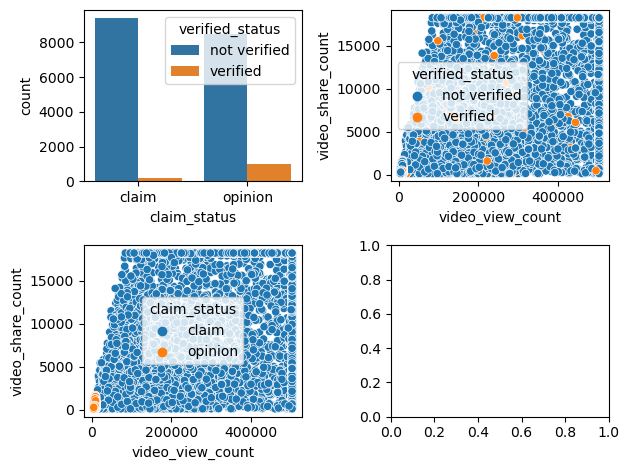

In [17]:
fig,axes=plt.subplots(2,2)
sns.countplot(data,x=data['claim_status'],hue=data['verified_status'],ax=axes[0,0])
sns.scatterplot(data,x=data['video_view_count'],y=data['video_share_count'], hue=data['verified_status'],ax=axes[0,1])
sns.scatterplot(data,x=data['video_view_count'],y=data['video_share_count'], hue=data['claim_status'], ax=axes[1,0])
plt.tight_layout()
plt.show()

In [18]:
data.columns

Index(['claim_status', 'video_id', 'video_duration_sec',
       'video_transcription_text', 'verified_status', 'author_ban_status',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count', 'transcription'],
      dtype='object')

In [19]:
# Create a contingency table for the two categorical variables
contingency_table = pd.crosstab(data['verified_status'], data['claim_status'])

# Perform chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print("Chi-Square Statistic:", chi2)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant association between 'verified_status' and 'claim_status'.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between 'verified_status' and 'claim_status'.")

Chi-Square Statistic: 554.0240857139472
p-value: 1.6772342420486568e-122
Reject the null hypothesis. There is a significant association between 'verified_status' and 'claim_status'.


In [20]:
data['verified_status'].unique()

array(['not verified', 'verified'], dtype=object)

In [21]:
#target variable = verified_status; checking for class imbalance
class_counts = data['verified_status'].value_counts()
class_counts

verified_status
not verified    17884
verified         1200
Name: count, dtype: int64

In [22]:
# Separate the majority and minority classes
majority_class = data[data['verified_status'] == 'not verified']
minority_class = data[data['verified_status'] == 'verified']

# Upsample the minority class to match the frequency of the majority class
upsampled_minority = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match the frequency of the majority class
                              random_state=42)  # Set random state for reproducibility

# Combine the upsampled minority class with the original majority class
data = pd.concat([majority_class, upsampled_minority])

# Display the class counts after upsampling
print("Class Counts After Upsampling:")
print(data['verified_status'].value_counts())

Class Counts After Upsampling:
verified_status
not verified    17884
verified        17884
Name: count, dtype: int64


### Correlation Matrix & Feature Selection

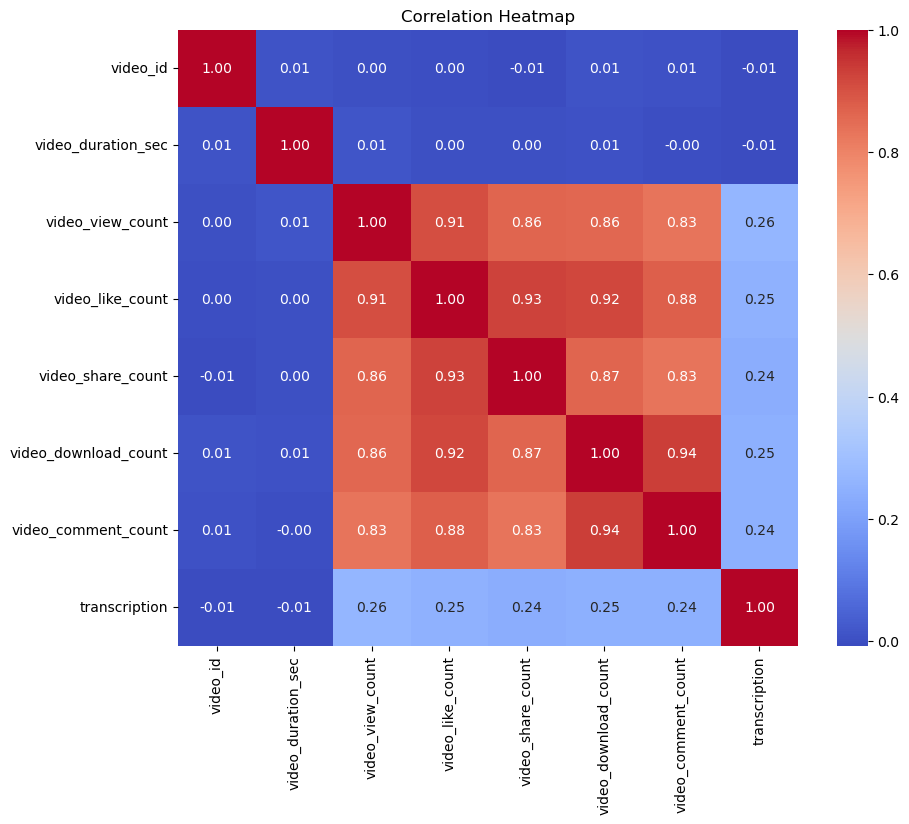

In [23]:
numeric_corr=['video_id', 'video_duration_sec', 'video_view_count','video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count','transcription']
correlation_matrix = data[numeric_corr].corr()
#correlation_matrix - identify pairs of highly correlated predictor variables
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.show()

In [24]:
# Calculate VIF - to check for multicollinearity
# Select numerical columns for VIF calculation
numeric_cols = data.select_dtypes(include=['number']).columns

# Compute VIF for numerical columns
X = data[numeric_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF and ANOVA results
print("Variance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
                feature        VIF
0              video_id   7.985920
1    video_duration_sec   6.796976
2      video_view_count   8.752430
3      video_like_count  19.808749
4     video_share_count  10.351553
5  video_download_count  17.090056
6   video_comment_count  11.469938
7         transcription  10.445230


In [25]:
data.columns

Index(['claim_status', 'video_id', 'video_duration_sec',
       'video_transcription_text', 'verified_status', 'author_ban_status',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count', 'transcription'],
      dtype='object')

In [26]:
# Drop non-numeric or non-essential columns if needed
data_for_rf = data.drop(columns=['claim_status', 'video_transcription_text'])

# Check if 'verified_status' is present in the DataFrame columns
if 'verified_status' in data_for_rf.columns:
    # Convert categorical variables to dummy variables if needed
    data_for_rf = pd.get_dummies(data_for_rf, drop_first=True)

    # Check if 'verified_status' is present after encoding
    if 'verified_status' in data_for_rf.columns:
        # Separate features and target variable
        X = data_for_rf.drop(columns=['verified_status'])
        y = data_for_rf['verified_status']

        # Initialize Random Forest Classifier
        rf = RandomForestClassifier()

        # Fit the model
        rf.fit(X, y)

        # Get feature importances
        feature_importances = rf.feature_importances_

        # Map feature names to their importance scores
        feature_importance_dict = dict(zip(X.columns, feature_importances))

        # Sort feature importance dictionary by values
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        # Print feature importances
        print("Feature Importances:")
        for feature, importance in sorted_feature_importance:
            print(f"{feature}: {importance}")

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_feature_importance)), [val for _, val in sorted_feature_importance], align='center')
        plt.yticks(range(len(sorted_feature_importance)), [feat for feat, _ in sorted_feature_importance])
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Random Forest Feature Importances')
        plt.show()
    else:
        print("'verified_status' column not found after encoding.")
else:
    print("'verified_status' column not found in the DataFrame.")


'verified_status' column not found after encoding.


C:\Users\archi\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature Importances:
transcription: 0.19549912059468993
video_view_count: 0.15965364584854477
video_id: 0.13378000974430887
video_like_count: 0.12919150731583717
video_share_count: 0.11156914783201302
video_duration_sec: 0.09566108273705531
video_download_count: 0.09254612807304684
video_comment_count: 0.06223948595740056
author_ban_status_under review: 0.011991203401925995
author_ban_status_banned: 0.007868668495177438


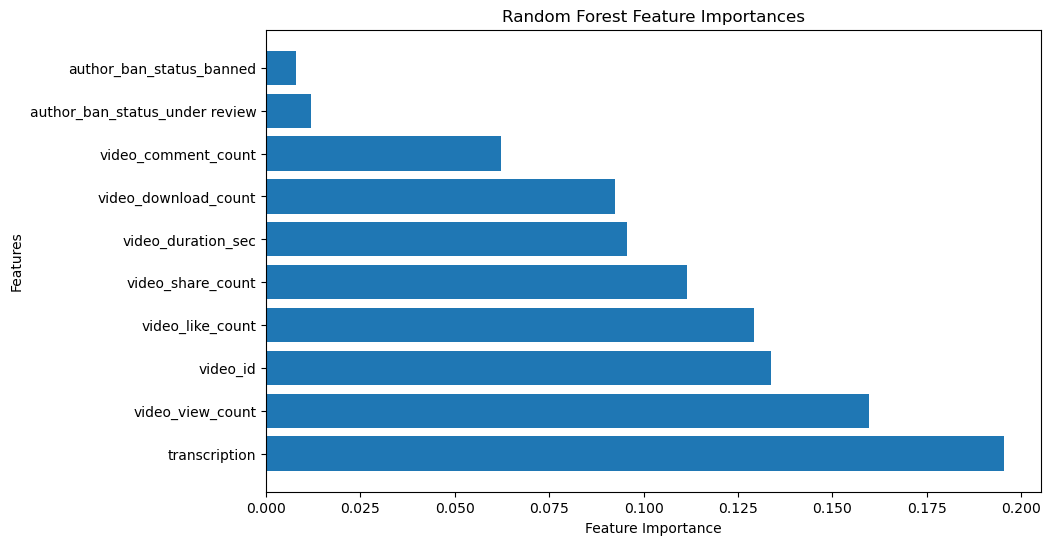

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Drop non-numeric or non-essential columns if needed
data_for_rf = data.drop(columns=['claim_status', 'video_transcription_text'])

# Convert categorical variables to dummy variables if needed
data_for_rf = pd.get_dummies(data_for_rf, drop_first=True)

# Separate features and target variable
X = data_for_rf.drop(columns=data_for_rf.filter(like='verified_status').columns)
y = data_for_rf.filter(like='verified_status')

# Initialize Random Forest Classifier
rf = RandomForestClassifier()

# Fit the model
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Map feature names to their importance scores
feature_importance_dict = dict(zip(X.columns, feature_importances))

# Sort feature importance dictionary by values
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importances
print("Feature Importances:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), [val for _, val in sorted_feature_importance], align='center')
plt.yticks(range(len(sorted_feature_importance)), [feat for feat, _ in sorted_feature_importance])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.show()


In [28]:
model_data=data[['claim_status', 'video_id', 'video_duration_sec',
       'video_transcription_text', 'verified_status', 'author_ban_status',
       'video_view_count', 'video_like_count', 'video_share_count',
        'video_comment_count', 'transcription']]
model_data.head()

,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_comment_count,transcription
0,claim,7.017666e+09,47,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,97
1,claim,4.014381e+09,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,18222.0,292.0,107
2,claim,7.840823e+09,31,someone shared with me that american industria...,not verified,active,504327.0,97690.0,2858.0,292.0,137
3,claim,3.425100e+09,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,125020.0,18222.0,292.0,131
4,claim,7.105231e+09,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,152.0,128


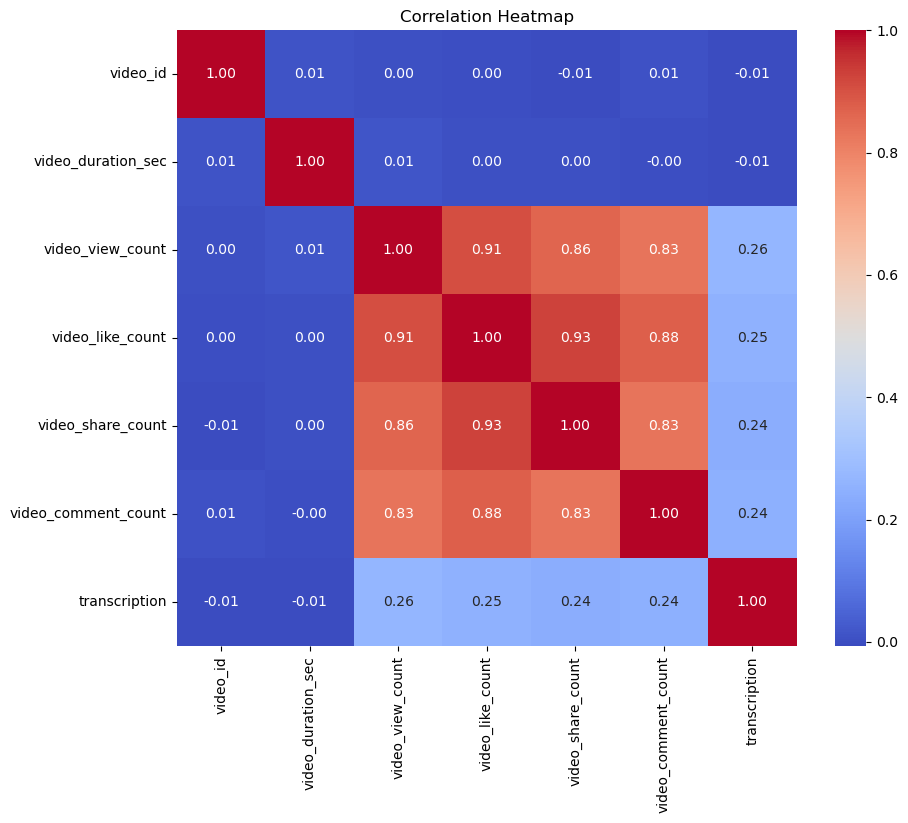

In [29]:
numeric_corr=['video_id', 'video_duration_sec', 'video_view_count','video_like_count', 'video_share_count', 'video_comment_count','transcription']
correlation_matrix = model_data[numeric_corr].corr()
#correlation_matrix - identify pairs of highly correlated predictor variables
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')  # Set the title of the heatmap
plt.show()

In [32]:
model_data.drop(columns='video_transcription_text', inplace=True)
model_data.columns
model_data.head()

C:\Users\archi\AppData\Local\Temp\ipykernel_11988\4192247635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.drop(columns='video_transcription_text', inplace=True)


,claim_status,video_id,video_duration_sec,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_comment_count,transcription
0,claim,7.017666e+09,47,not verified,under review,343296.0,19425.0,241.0,1.0,97
1,claim,4.014381e+09,32,not verified,active,140877.0,77355.0,18222.0,292.0,107
2,claim,7.840823e+09,31,not verified,active,504327.0,97690.0,2858.0,292.0,137
3,claim,3.425100e+09,25,not verified,active,437506.0,125020.0,18222.0,292.0,131
4,claim,7.105231e+09,19,not verified,active,56167.0,34987.0,4110.0,152.0,128


In [33]:
# Step 1: Encode categorical features
model_data_encoded = pd.get_dummies(model_data, columns=['claim_status', 'author_ban_status'], drop_first=True)

# Step 2: Separate target variable from input features
X = model_data_encoded.drop(columns=['verified_status'])
y = model_data['verified_status']

# Step 3: Split the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Step 4: Train a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Step 5: Evaluate the model on the test set
y_pred = logreg.predict(X_test)

In [34]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='verified')  # Set pos_label to the label corresponding to the positive class
recall = recall_score(y_test, y_pred, pos_label='verified')  # Set pos_label to the label corresponding to the positive class
f1 = f1_score(y_test, y_pred, pos_label='verified')  # Set pos_label to the label corresponding to the positive class

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Model Evaluation Metrics:
Accuracy: 0.662255358807083
Precision: 0.6164091635588705
Recall: 0.8615040953090097
F1-score: 0.7186335403726708


Confusion Matrix:
[[1239 1440]
 [ 372 2314]]
Classification Report:
              precision    recall  f1-score   support

not verified       0.77      0.46      0.58      2679
    verified       0.62      0.86      0.72      2686

    accuracy                           0.66      5365
   macro avg       0.69      0.66      0.65      5365
weighted avg       0.69      0.66      0.65      5365



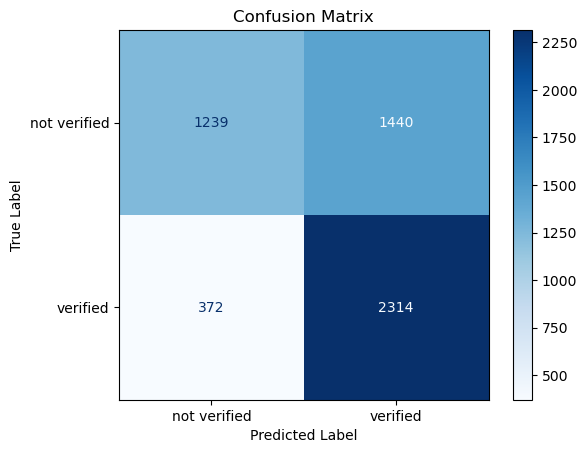

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Step 6: Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 7: Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Step 8: Calculate precision, recall, and F1-score for each class
class_names = ['not verified', 'verified']
report = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Step 9: Visualize confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [36]:
model2_data=data[['claim_status', 'video_id', 'video_duration_sec',
        'verified_status', 'author_ban_status','video_download_count',
       'video_view_count',  'video_share_count',
        'video_comment_count', 'transcription']]
model2_data.head()

,claim_status,video_id,video_duration_sec,verified_status,author_ban_status,video_download_count,video_view_count,video_share_count,video_comment_count,transcription
0,claim,7.017666e+09,47,not verified,under review,7.00,343296.0,241.0,1.0,97
1,claim,4.014381e+09,32,not verified,active,1156.25,140877.0,18222.0,292.0,107
2,claim,7.840823e+09,31,not verified,active,833.00,504327.0,2858.0,292.0,137
3,claim,3.425100e+09,25,not verified,active,1156.25,437506.0,18222.0,292.0,131
4,claim,7.105231e+09,19,not verified,active,547.00,56167.0,4110.0,152.0,128


In [37]:
# Step 1: Encode categorical features
model2_data_encoded = pd.get_dummies(model2_data, columns=['claim_status', 'author_ban_status'], drop_first=True)

# Step 2: Separate target variable from input features
X = model2_data_encoded.drop(columns=['verified_status'])
y = model2_data['verified_status']

# Step 3: Split the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Step 4: Train a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Step 5: Evaluate the model on the test set
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy1 = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred, pos_label='verified')  # Set pos_label to the label corresponding to the positive class
recall1 = recall_score(y_test, y_pred, pos_label='verified')  # Set pos_label to the label corresponding to the positive class
f11 = f1_score(y_test, y_pred, pos_label='verified')  # Set pos_label to the label corresponding to the positive class

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy1}")
print(f"Precision: {precision1}")
print(f"Recall: {recall1}")
print(f"F1-score: {f11}")

Model Evaluation Metrics:
Accuracy: 0.6631873252562908
Precision: 0.6169816342826724
Recall: 0.8629932985852569
F1-score: 0.7195405866832222


Confusion Matrix:
[[1240 1439]
 [ 368 2318]]
Classification Report:
              precision    recall  f1-score   support

not verified       0.77      0.46      0.58      2679
    verified       0.62      0.86      0.72      2686

    accuracy                           0.66      5365
   macro avg       0.69      0.66      0.65      5365
weighted avg       0.69      0.66      0.65      5365



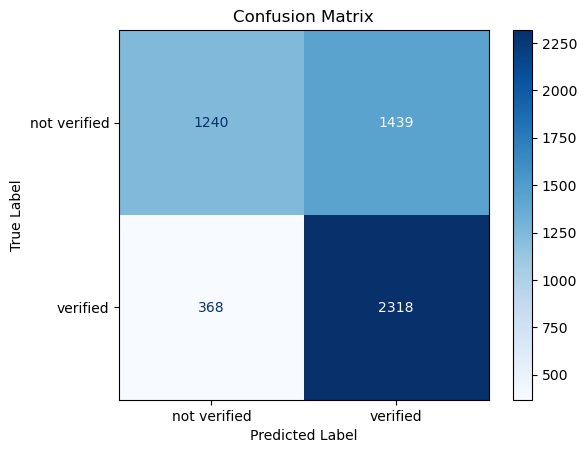

In [38]:
# Step 6: Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 7: Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Step 8: Calculate precision, recall, and F1-score for each class
class_names = ['not verified', 'verified']
report = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Step 9: Visualize confusion matrix
disp1 = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp1.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

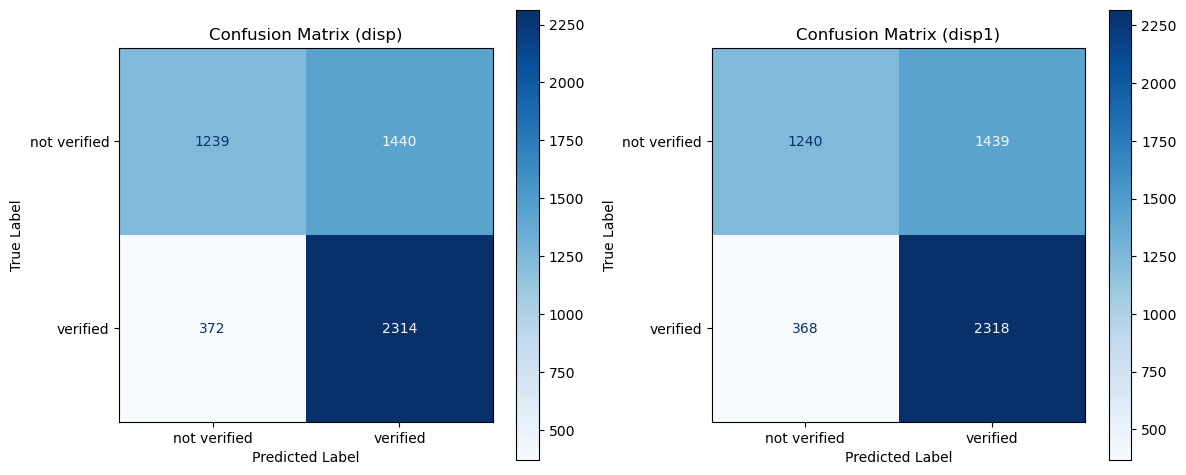

In [39]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot first confusion matrix
disp.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix (disp)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot second confusion matrix
disp1.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix (disp1)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

##### removing the most correlated column, slightly improved the model

In [40]:
# Get the feature names
feature_names = X_train.columns

# Get the coefficients of the logistic regression model
coefficients = logreg.coef_[0]

# Create a DataFrame to store the feature names and coefficients
coefficients_df = pd.DataFrame({'Feature Name': feature_names, 'Model Coefficient': coefficients})

# Print or display the DataFrame
print(coefficients_df)


                     Feature Name  Model Coefficient
0                        video_id       7.030618e-11
1              video_duration_sec      -1.286178e-11
2            video_download_count      -7.085039e-09
3                video_view_count      -3.417536e-06
4               video_share_count      -1.092142e-07
5             video_comment_count      -1.701491e-09
6                   transcription      -1.400626e-10
7            claim_status_opinion       9.138900e-12
8        author_ban_status_banned      -1.350883e-12
9  author_ban_status_under review      -1.250439e-12


### Interpretation

New Goal: Model to predict if a video is claim or opinion. 

Why - Mostly claim videos get reported & require tedious human intervention (review).Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review.
Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator
In this case,
  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim

The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. So, its important to have lower false negatives than false positives. Hence Evaluation metric of interest is **Recall**


In [43]:
final_model=data
data_save=data
final_model.head()

,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,transcription
0,claim,7.017666e+09,47,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,7.00,1.0,97
1,claim,4.014381e+09,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,18222.0,1156.25,292.0,107
2,claim,7.840823e+09,31,someone shared with me that american industria...,not verified,active,504327.0,97690.0,2858.0,833.00,292.0,137
3,claim,3.425100e+09,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,125020.0,18222.0,1156.25,292.0,131
4,claim,7.105231e+09,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.00,152.0,128


In [46]:



data = final_model.copy()

# Drop irrelevant columns
data.drop(columns=['video_transcription_text'], inplace=True)

# Encode categorical variables if necessary
data_encoded = pd.get_dummies(data, columns=['claim_status', 'author_ban_status'], drop_first=True)

# Split the data into train-test-valid sets (60-20-20)
X = data_encoded.drop(columns=['verified_status'])
y = data_encoded['verified_status']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Define hyperparameters for grid search
param_grid = {
    'Random Forest': {
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'Gradient Boosting': {
        'max_depth': [3, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'max_features': [None, 'sqrt', 'log2']
    },
    'XGBoost': {
        'max_depth': [3, 5, 10],
        'min_child_weight': [1, 3, 5],
        'gamma': [0.0, 0.1, 0.2]
    }
}

# Grid Search with cross-validation to find the best parameters for each model
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

# Evaluate each model
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred, pos_label='verified')
    recall = recall_score(y_valid, y_pred, pos_label='verified')
    precision = precision_score(y_valid, y_pred, pos_label='verified')
    f1 = f1_score(y_valid, y_pred, pos_label='verified')
    results[name] = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1}

# Select the best model based on performance metrics
best_model_name = max(results, key=lambda k: results[k]['F1 Score'])
best_model = best_models[best_model_name]

# Confusion Matrix of the best model
y_pred_test = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print results and confusion matrix
print("Model Evaluation Metrics:")
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")

print("Confusion Matrix of the Best Model:")
print(conf_matrix)


C:\Users\archi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\archi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\archi\anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\archi\anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\archi\anaconda3\lib\site-packages

KeyboardInterrupt: 

In [51]:
data = final_model.copy()

# Drop irrelevant columns
data.drop(columns=['video_transcription_text'], inplace=True)

# Encode categorical variables if necessary
data_encoded = pd.get_dummies(data, columns=['claim_status', 'author_ban_status'], drop_first=True)

# Split the data into train-test-valid sets (60-20-20)
X = data_encoded.drop(columns=['verified_status'])
y = data_encoded['verified_status']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define hyperparameters for grid search
param_grid = {
    'max_depth': [None, 10, 20],
    'max_features': [0.3, 0.6],
    'min_samples_leaf': [1, 5],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [50, 100, 200]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier()

# Grid Search with cross-validation to find the best parameters
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='recall',refit='recall')
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the best Random Forest model
y_pred_rf = best_rf_model.predict(X_valid)
accuracy_rf = accuracy_score(y_valid, y_pred_rf, pos_label='verified')
recall_rf = recall_score(y_valid, y_pred_rf, pos_label='verified')
precision_rf = precision_score(y_valid, y_pred_rf, pos_label='verified')
f1_rf = f1_score(y_valid, y_pred_rf, pos_label='verified')

# Confusion Matrix of the best Random Forest model
conf_matrix_rf = confusion_matrix(y_test, best_rf_model.predict(X_test))

# Print evaluation metrics and confusion matrix for Random Forest
print("Random Forest Evaluation Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
print(conf_matrix_rf)

C:\Users\archi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\archi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\archi\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\archi\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\archi\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\archi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 229

TypeError: got an unexpected keyword argument 'pos_label'

In [ ]:
# Define hyperparameters for grid search
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'n_estimators': [50, 100, 200]
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier()

# Grid Search with cross-validation to find the best parameters
grid_search_gb = GridSearchCV(gb_model, param_grid, cv=5, scoring='recall')
grid_search_gb.fit(X_train, y_train)
best_gb_model = grid_search_gb.best_estimator_

# Evaluate the best Gradient Boosting model
y_pred_gb = best_gb_model.predict(X_valid)
accuracy_gb = accuracy_score(y_valid, y_pred_gb, pos_label='verified')
recall_gb = recall_score(y_valid, y_pred_gb, pos_label='verified')
precision_gb = precision_score(y_valid, y_pred_gb, pos_label='verified')
f1_gb = f1_score(y_valid, y_pred_gb, pos_label='verified')

# Confusion Matrix of the best Gradient Boosting model
conf_matrix_gb = confusion_matrix(y_test, best_gb_model.predict(X_test))

# Print evaluation metrics and confusion matrix for Gradient Boosting
print("Gradient Boosting Evaluation Metrics:")
print(f"Accuracy: {accuracy_gb}")
print(f"Recall: {recall_gb}")
print(f"Precision: {precision_gb}")
print(f"F1 Score: {f1_gb}")
print("Confusion Matrix:")
print(conf_matrix_gb)

In [ ]:
# Define hyperparameters for grid search
param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Grid Search with cross-validation to find the best parameters
grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring='recall')
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best XGBoost model
y_pred_xgb = best_xgb_model.predict(X_valid)
accuracy_xgb = accuracy_score(y_valid, y_pred_xgb, pos_label='verified')
recall_xgb = recall_score(y_valid, y_pred_xgb, pos_label='verified')
precision_xgb = precision_score(y_valid, y_pred_xgb, pos_label='verified')
f1_xgb = f1_score(y_valid, y_pred_xgb, pos_label='verified')

# Confusion Matrix of the best XGBoost model
conf_matrix_xgb = confusion_matrix(y_test, best_xgb_model.predict(X_test))

# Print evaluation metrics and confusion matrix for XGBoost
print("XGBoost Evaluation Metrics:")
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall: {recall_xgb}")
print(f"Precision: {precision_xgb}")
print(f"F1 Score: {f1_xgb}")
print("Confusion Matrix:")
print(conf_matrix_xgb)